# Housing Prices

# Intro 

Hello everyone,

This is my notebook for the Housing Prices Competition. A major focus for me was to practice my feature engineering. As a result, I went through each column individually to see what I could do to simplify or fill null values. I am sure I will learn ways to do this in bulk faster, but I wanted to just go through one by one to get familiar with the process. As a result I ended up using many different types of transformations including aggregates, ordinal encoding, and one hot encoding.

I won't go through each column individually in my notes unless there is a call for it, so if you would like more explanation let me know!

## Update

I added model tuning to the notebook and was able to place in the top 1%! 

# Import Libraries

Here I did a few things. 

- First, I of course imported the libraries I would need. 
- Secondly, this data includes columns that include years. I wanted to change these from the year it occurred to how many years ago to help scale the data. To help with this I created a variable to hold the current date.
- Lastly, I changed an option in pandas to show all columns

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

import datetime

# Created a year variable that I use later on for columns involving dates
date = datetime.date.today()
year = date.strftime("%Y")

# Set it so I would see all columns when I looked at DFs
pd.set_option('max_columns', None)

# Create DataFrames

Here I created the DataFrames that will be used. I made a version for just training, and testing as well as one that include all information. During the feature engineering I only worked with the training DF.

In [8]:
import os
for dirname, _, filenames in os.walk(''):
    for filename in filenames:
        print(os.path.join(dirname, filename))

test = pd.read_csv('data/test.csv', index_col=0)
training = pd.read_csv('data/train.csv', index_col=0)

training['train_test'] = 1
test['train_test'] = 0
test['SalePrice'] = np.NaN
all_data = pd.concat([training,test])
all_data.columns

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if sys.path[0] == '':


Index(['1stFlrSF', '2ndFlrSF', '3SsnPorch', 'Alley', 'BedroomAbvGr',
       'BldgType', 'BsmtCond', 'BsmtExposure', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtFinType1', 'BsmtFinType2', 'BsmtFullBath', 'BsmtHalfBath',
       'BsmtQual', 'BsmtUnfSF', 'CentralAir', 'Condition1', 'Condition2',
       'Electrical', 'EnclosedPorch', 'ExterCond', 'ExterQual', 'Exterior1st',
       'Exterior2nd', 'Fence', 'FireplaceQu', 'Fireplaces', 'Foundation',
       'FullBath', 'Functional', 'GarageArea', 'GarageCars', 'GarageCond',
       'GarageFinish', 'GarageQual', 'GarageType', 'GarageYrBlt', 'GrLivArea',
       'HalfBath', 'Heating', 'HeatingQC', 'HouseStyle', 'KitchenAbvGr',
       'KitchenQual', 'LandContour', 'LandSlope', 'LotArea', 'LotConfig',
       'LotFrontage', 'LotShape', 'LowQualFinSF', 'MSSubClass', 'MSZoning',
       'MasVnrArea', 'MasVnrType', 'MiscFeature', 'MiscVal', 'MoSold',
       'Neighborhood', 'OpenPorchSF', 'OverallCond', 'OverallQual',
       'PavedDrive', 'PoolArea', 'PoolQC',

# EDA

In [9]:
def understanding(df):
    print(df.info())
    print(df.describe())
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            plt.hist(df[col])
            plt.title(col)
            plt.show()
            plt.clf()
        elif df[col].dtype == 'object':
            sns.barplot(df[col].value_counts().index,df[col].value_counts()).set_title(col)
            plt.show()
            
def heat(df):
    num_columns = []
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            num_columns.append(col)
    sns.heatmap(df[num_columns].corr(), annot=True)
    
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [10]:
training.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,train_test
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,1
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,1
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,1
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,1
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,1


In [11]:
print(training.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

In [12]:
training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 81 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 81 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

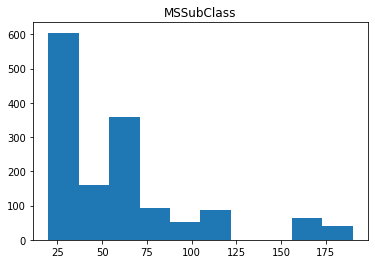

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


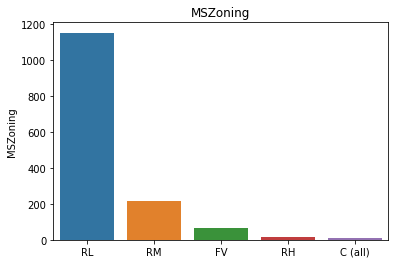

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


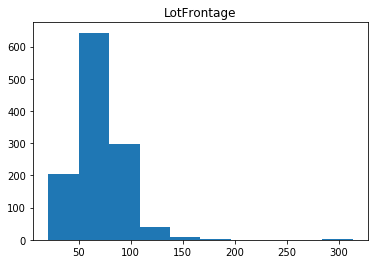

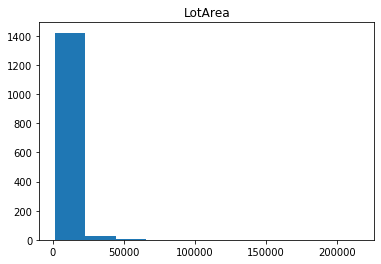

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


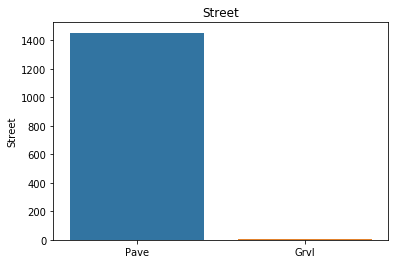

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


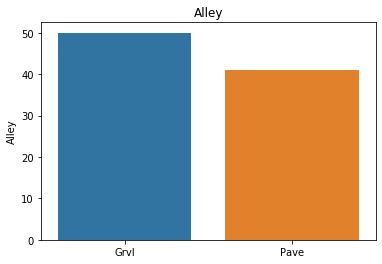

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


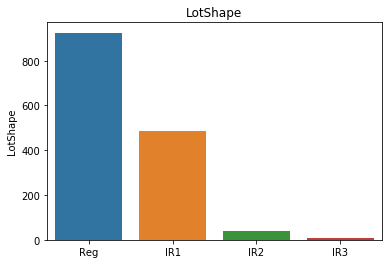

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


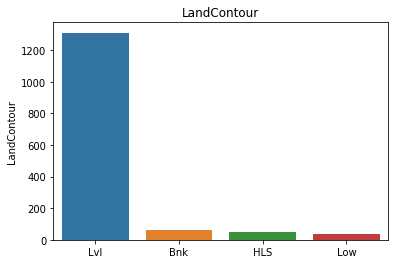

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


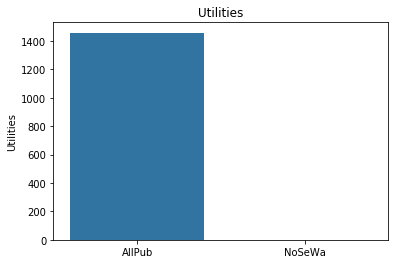

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


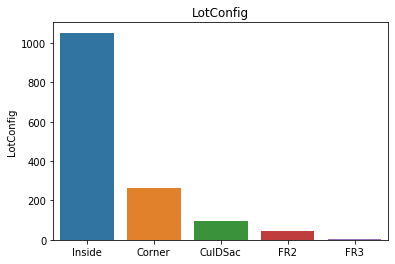

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


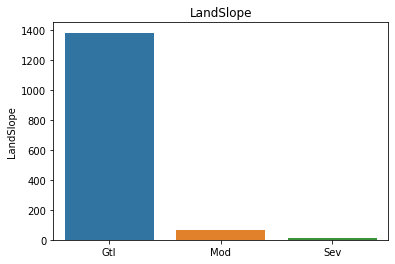

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


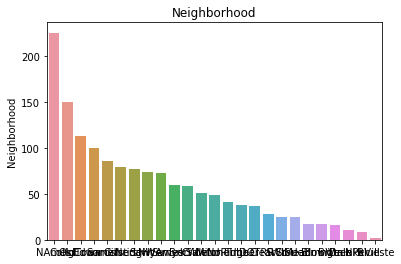

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


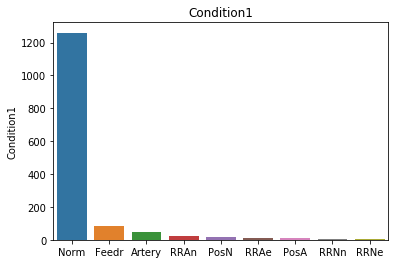

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


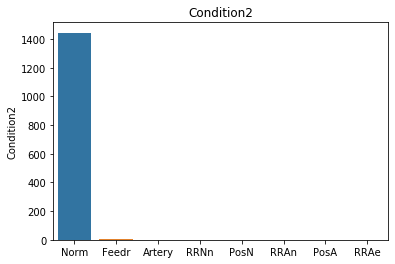

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


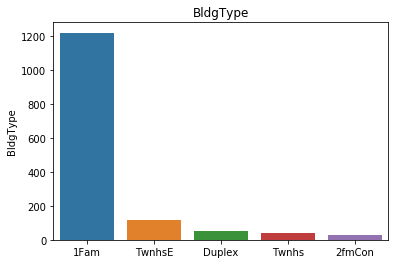

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


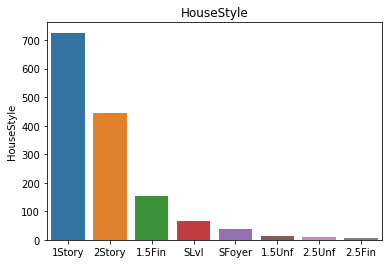

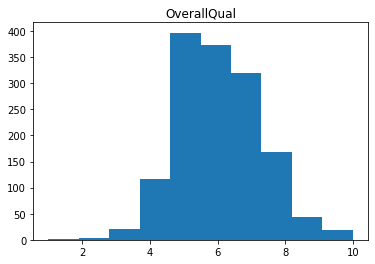

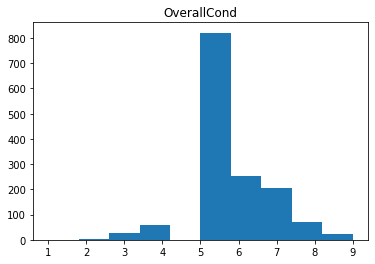

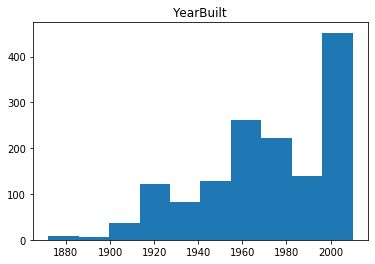

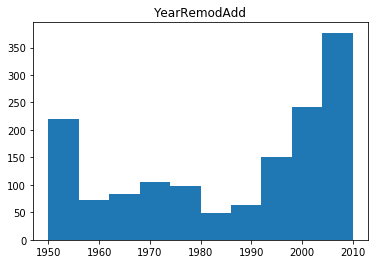

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


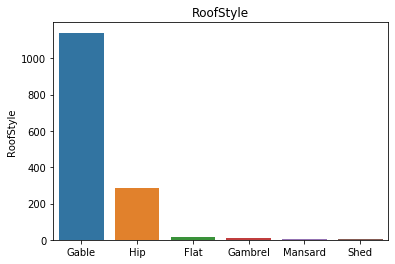

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


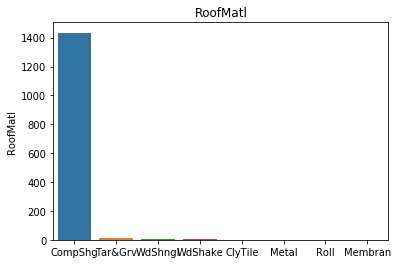

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


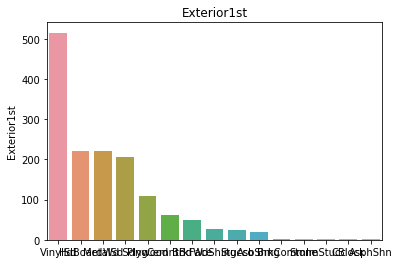

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


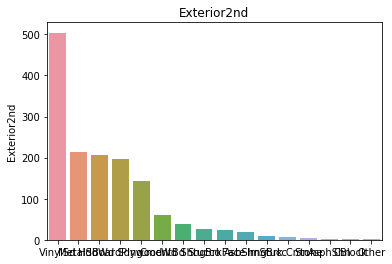

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


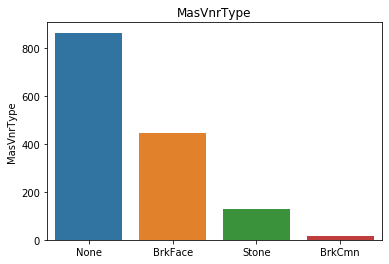

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


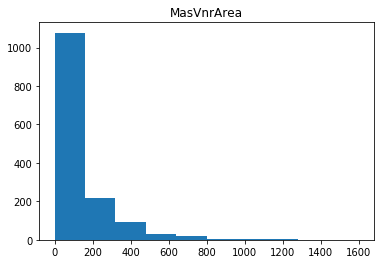

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


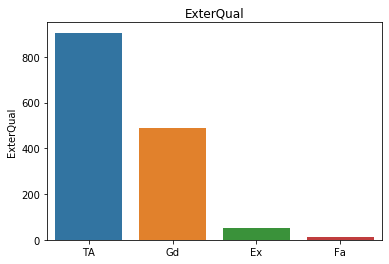

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


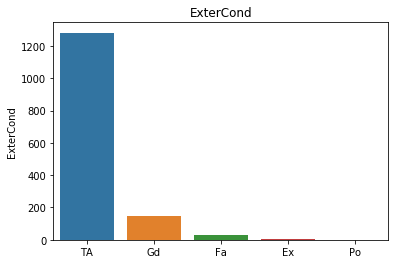

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


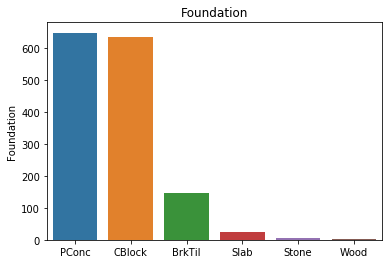

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


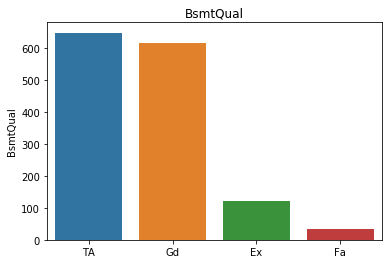

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


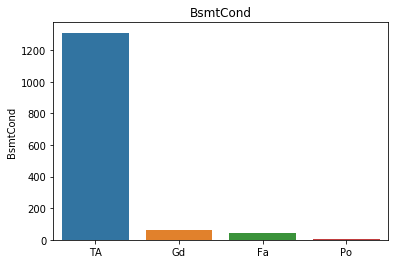

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


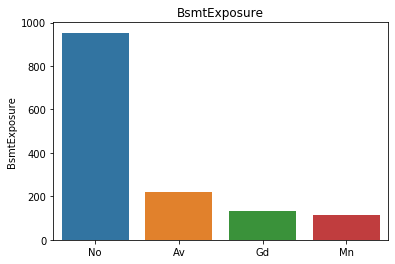

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


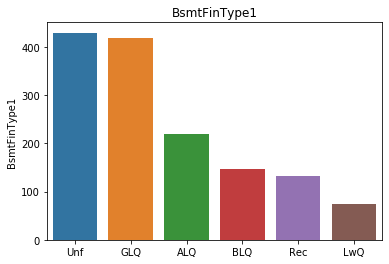

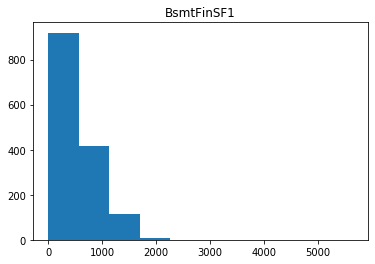

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


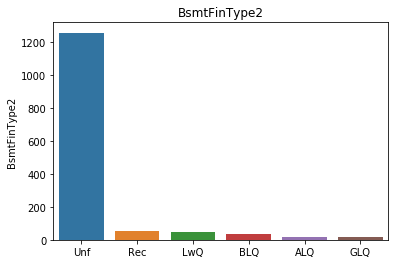

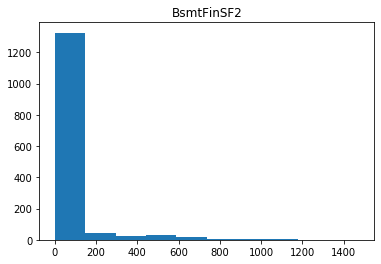

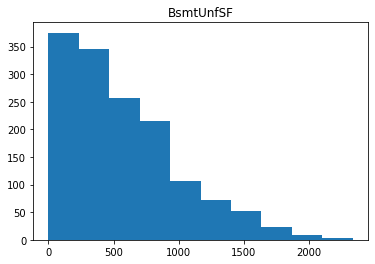

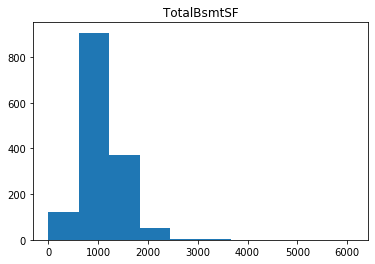

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


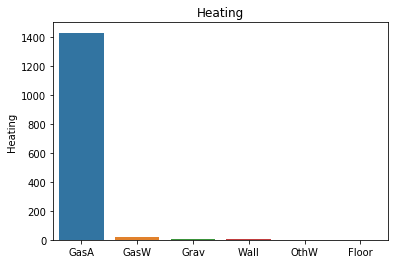

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


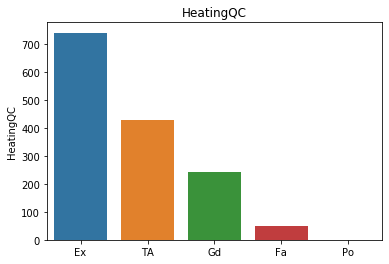

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


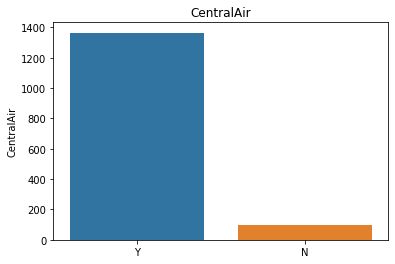

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


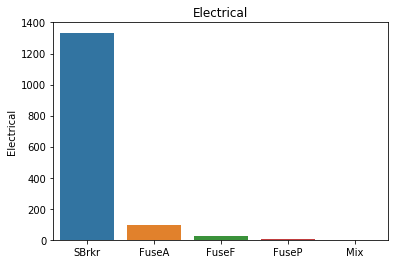

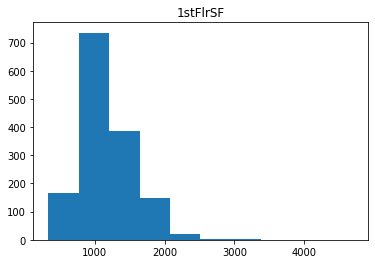

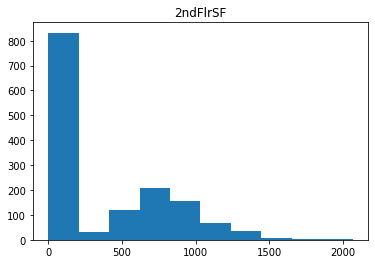

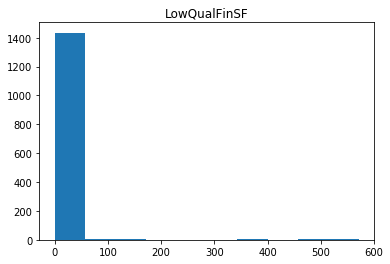

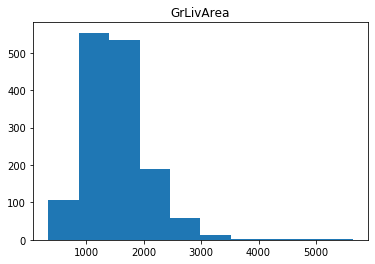

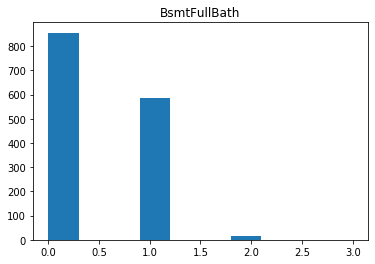

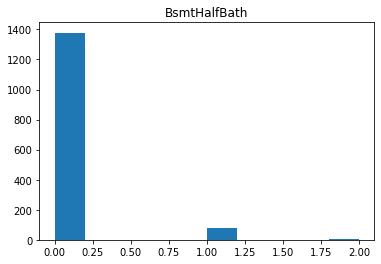

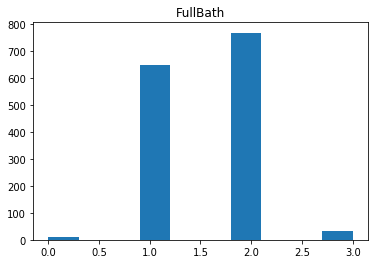

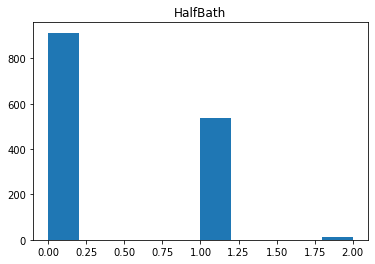

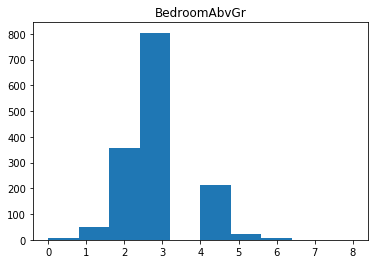

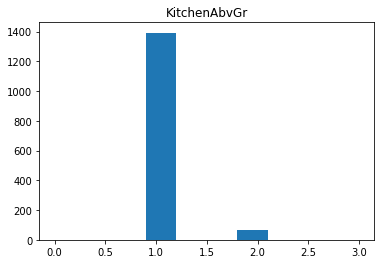

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


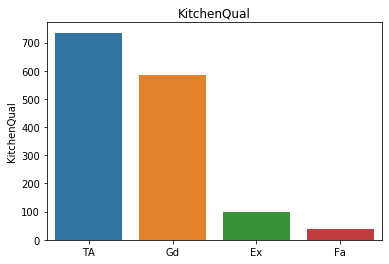

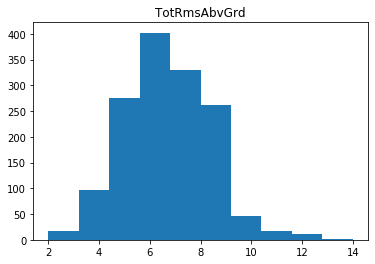

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


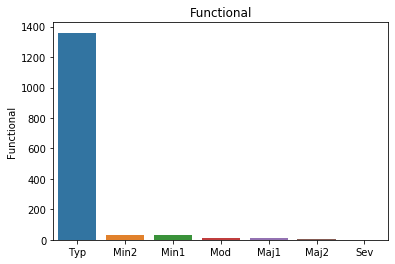

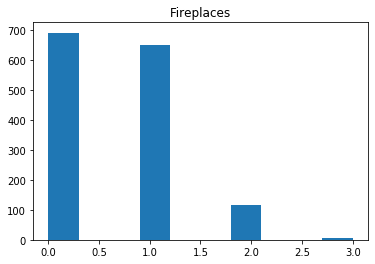

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


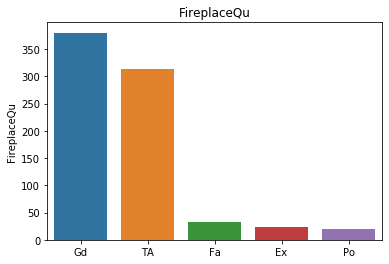

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


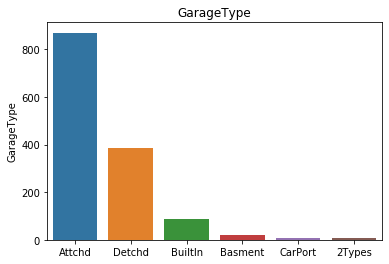

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


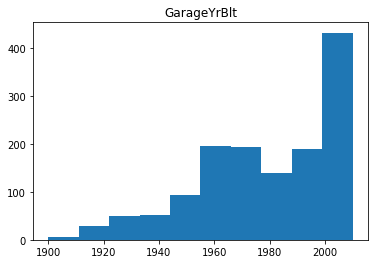

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


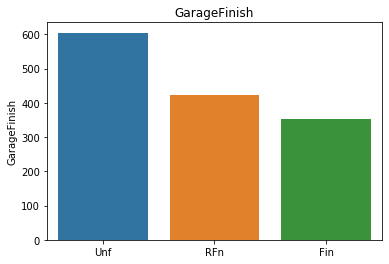

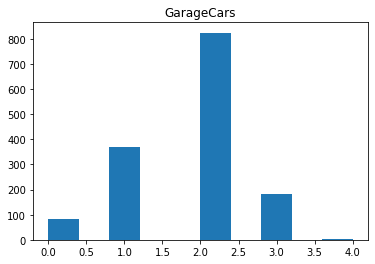

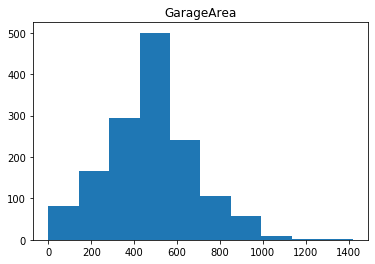

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


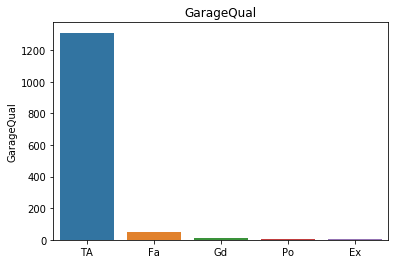

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


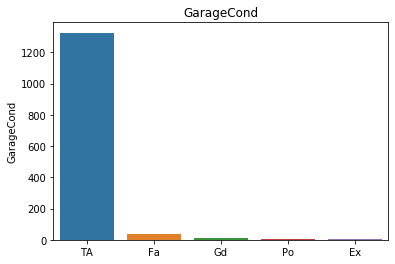

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


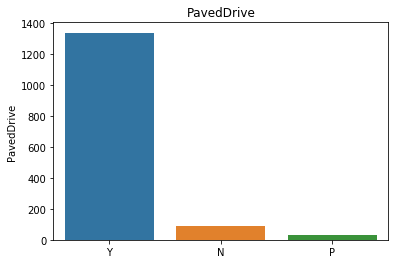

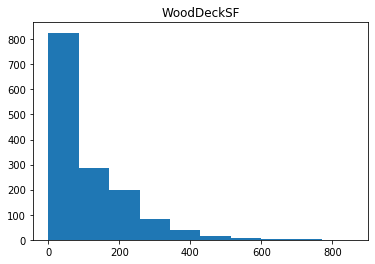

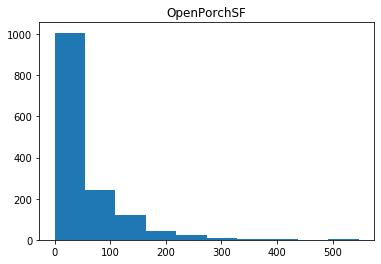

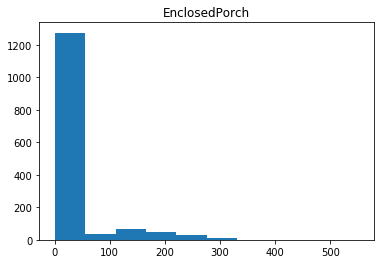

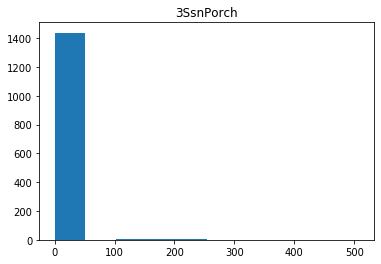

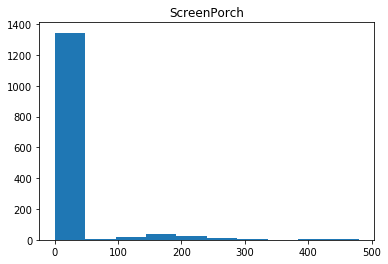

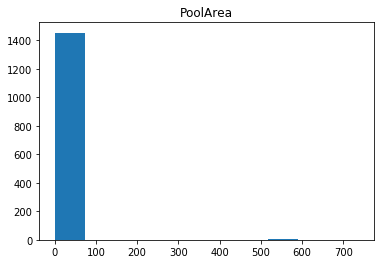

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


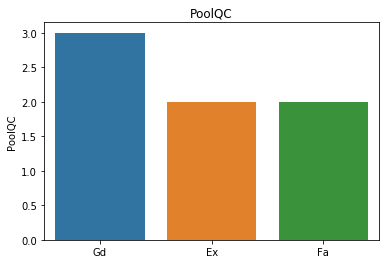

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


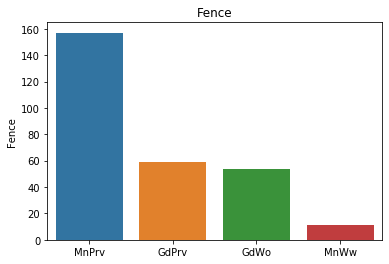

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


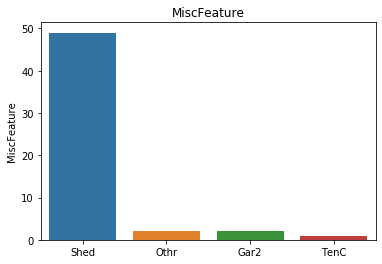

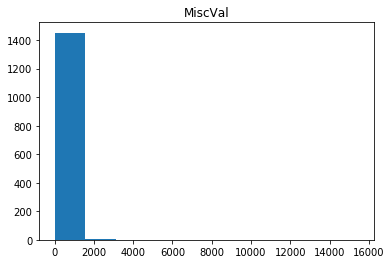

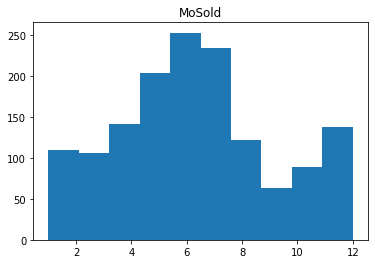

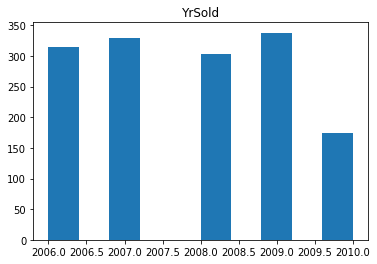

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


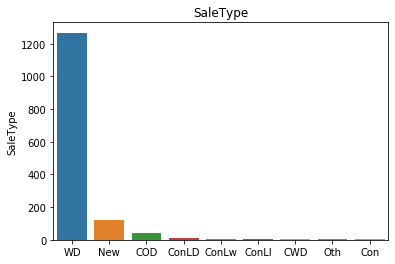

C:\Users\Ryan Park\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


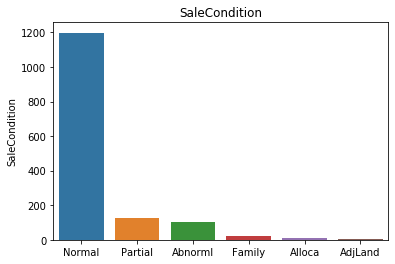

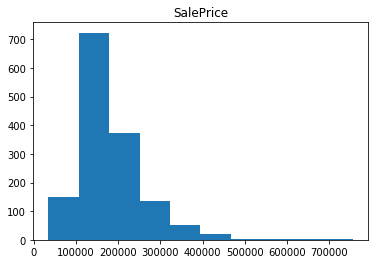

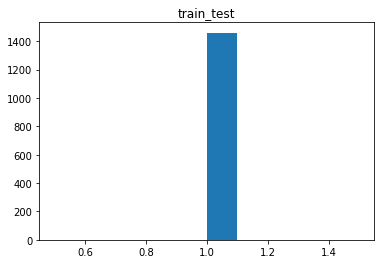

<Figure size 432x288 with 0 Axes>

In [13]:
understanding(training)

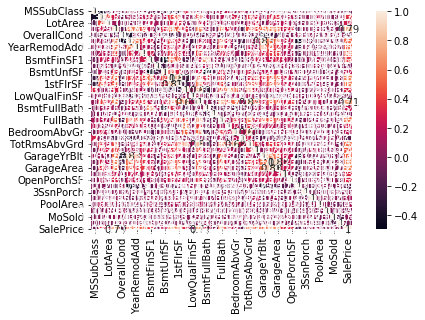

In [14]:
heat(training)


In [15]:
corr = correlation(training, .8)
corr_array = []
for col in corr:
    corr_array.append(col)
corr_array

['TotRmsAbvGrd', 'GarageArea', 'GarageYrBlt', '1stFlrSF']

# Feature Engineering

In [16]:
print(training.MSSubClass.value_counts())

mssub_others = [190, 85, 75, 45, 180, 40]

training.MSSubClass = training.MSSubClass.apply(lambda x: str('other') if x in mssub_others else str(x))

print(training.MSSubClass.value_counts())

20     536
60     299
50     144
120     87
30      69
160     63
70      60
80      58
90      52
190     30
85      20
75      16
45      12
180     10
40       4
Name: MSSubClass, dtype: int64
20       536
60       299
50       144
other     92
120       87
30        69
160       63
70        60
80        58
90        52
Name: MSSubClass, dtype: int64


In [17]:

print(training.MSZoning.value_counts())

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


In [18]:
mszoning_others = ['FV', 'RH', 'C (all)']
training.MSZoning = training.MSZoning.apply(lambda x: str('Other') if x in mszoning_others else str(x))
print(training.MSZoning.value_counts())

RL       1151
RM        218
Other      91
Name: MSZoning, dtype: int64


60.0     143
70.0      70
80.0      69
50.0      57
75.0      53
65.0      44
85.0      40
78.0      25
21.0      23
90.0      23
68.0      19
24.0      19
64.0      19
73.0      18
72.0      17
79.0      17
63.0      17
55.0      17
100.0     16
51.0      15
66.0      15
74.0      15
52.0      14
59.0      13
71.0      12
82.0      12
40.0      12
43.0      12
67.0      12
57.0      12
        ... 
129.0      2
124.0      2
118.0      2
101.0      2
122.0      2
121.0      2
115.0      2
109.0      2
116.0      2
114.0      2
150.0      1
111.0      1
153.0      1
182.0      1
46.0       1
112.0      1
149.0      1
141.0      1
33.0       1
152.0      1
160.0      1
168.0      1
128.0      1
144.0      1
39.0       1
106.0      1
38.0       1
138.0      1
140.0      1
137.0      1
Name: LotFrontage, Length: 110, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


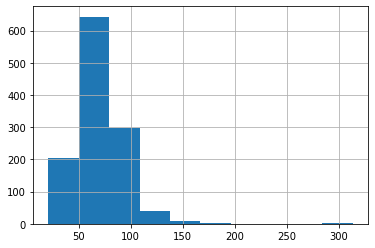

In [19]:
print(training.LotFrontage.value_counts())
print(training.LotFrontage.hist())

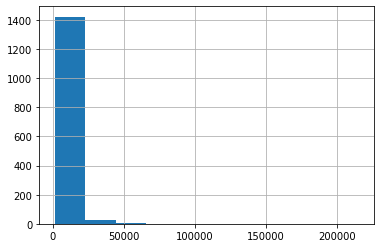

In [20]:
training.LotArea.hist()

In [21]:
print(training.Street.value_counts())
training['Street_Pave'] = training.Street.apply(lambda x: 1 if x == 'Pave' else 0)
training.Street_Pave.value_counts()

Pave    1454
Grvl       6
Name: Street, dtype: int64


1    1454
0       6
Name: Street_Pave, dtype: int64

In [22]:
print(training.Alley.value_counts())
training.Alley = training.Alley.apply(lambda x: 1 if type(x) == str else 0)
training.Alley.value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64


0    1369
1      91
Name: Alley, dtype: int64

In [23]:
training.LotShape.value_counts()
lotshape_others = ['IR2', 'IR3']
training.LotShape = training.LotShape.apply(lambda x: 'Other' if x in lotshape_others else x)
training.LotShape.value_counts()

Reg      925
IR1      484
Other     51
Name: LotShape, dtype: int64

In [24]:
training.LandContour.value_counts()
training['LandContour_Flat'] = training.LandContour.apply(lambda x: 1 if x == 'Lvl' else 0)
training.LandContour_Flat.value_counts()

1    1311
0     149
Name: LandContour_Flat, dtype: int64

In [25]:
training.Utilities.value_counts()

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64

In [26]:
training.LotConfig.value_counts()
training.LotConfig = training.LotConfig.apply(lambda x: 'Other' if x == 'FR2' or x == 'FR3' else x)
training.LotConfig.value_counts()

Inside     1052
Corner      263
CulDSac      94
Other        51
Name: LotConfig, dtype: int64

In [27]:
training.LandSlope.value_counts()
training['LandSlope_Gentle'] = training.LandSlope.apply(lambda x: 1 if x == 'Gtl' else 0)
training.LandSlope_Gentle.value_counts()

1    1382
0      78
Name: LandSlope_Gentle, dtype: int64

In [28]:
training.Neighborhood.value_counts()

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
SWISU       25
StoneBr     25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64

In [29]:
training.Condition1.value_counts()
pos_condition = ['Feedr', 'Artery', 'PosN', 'PosA']
rr_condition = ['RRAe', 'RRAn', 'RRNn', 'RRNe']
training.Condition1 = training.Condition1.apply(lambda x: 'Pos' if x in pos_condition else x)
training.Condition1 = training.Condition1.apply(lambda x: 'RR' if x in rr_condition else x)
training.Condition1.value_counts()

Norm    1260
Pos      156
RR        44
Name: Condition1, dtype: int64

In [30]:
training.Condition2.value_counts()
pos_condition = ['Feedr', 'Artery', 'PosN', 'PosA']
rr_condition = ['RRAe', 'RRAn', 'RRNn', 'RRNe']
training.Condition2 = training.Condition2.apply(lambda x: 'Pos' if x in pos_condition else x)
training.Condition2 = training.Condition2.apply(lambda x: 'RR' if x in rr_condition else x)
training.Condition2.value_counts()

Norm    1445
Pos       11
RR         4
Name: Condition2, dtype: int64

In [31]:
training.BldgType.value_counts()

1Fam      1220
TwnhsE     114
Duplex      52
Twnhs       43
2fmCon      31
Name: BldgType, dtype: int64

In [32]:
training.HouseStyle.value_counts()

1Story    726
2Story    445
1.5Fin    154
SLvl       65
SFoyer     37
1.5Unf     14
2.5Unf     11
2.5Fin      8
Name: HouseStyle, dtype: int64

In [33]:
training.OverallQual.value_counts()

5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: OverallQual, dtype: int64

In [34]:
training.OverallCond.value_counts()

5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

2006    67
2005    64
2004    54
2007    49
2003    45
1976    33
1977    32
1920    30
1959    26
1999    25
1998    25
1958    24
1965    24
1970    24
1954    24
2000    24
2002    23
2008    23
1972    23
1968    22
1971    22
1950    20
2001    20
1957    20
1962    19
1994    19
1966    18
2009    18
1995    18
1940    18
        ..
1986     5
1952     5
1880     4
1929     4
1932     4
1938     4
1983     4
1927     3
1919     3
1934     3
1989     3
1987     3
1912     3
1885     2
1892     2
1890     2
1942     2
1908     2
1882     1
1875     1
1893     1
2010     1
1898     1
1904     1
1905     1
1906     1
1911     1
1913     1
1917     1
1872     1
Name: YearBuilt, Length: 112, dtype: int64


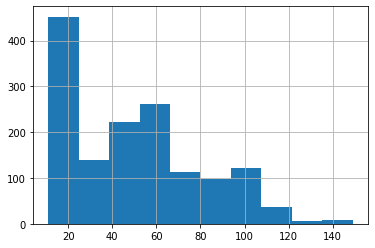

In [35]:
print(training.YearBuilt.value_counts())

date = datetime.date.today()
year = int(date.strftime("%Y"))

training['Year_Old'] = training.YearBuilt.apply(lambda x: year - x)
training.Year_Old.value_counts()
training.Year_Old.hist()

1950    178
2006     97
2007     76
2005     73
2004     62
2000     55
2003     51
2002     48
2008     40
1996     36
1998     36
1995     31
1976     30
1999     30
1970     26
1997     25
1977     25
2009     23
1994     22
2001     21
1972     20
1965     19
1993     19
1971     18
1959     18
1968     17
1992     17
1978     16
1966     15
1958     15
       ... 
1962     14
1954     14
1969     14
1991     14
1963     13
1960     12
1967     12
1980     12
1973     11
1964     11
1989     11
1987     10
1975     10
1979     10
1956     10
1953     10
1957      9
1988      9
1955      9
1985      9
1961      8
1981      8
1974      7
1982      7
1984      7
2010      6
1983      5
1952      5
1986      5
1951      4
Name: YearRemodAdd, Length: 61, dtype: int64
71    178
15     97
14     76
16     73
17     62
21     55
18     51
19     48
13     40
25     36
23     36
26     31
45     30
22     30
51     26
24     25
44     25
12     23
27     22
20     21
49     20
28     19
56 

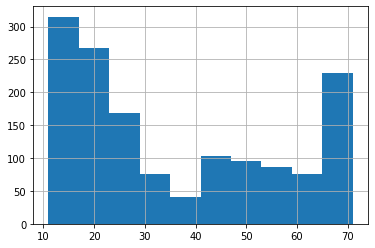

In [37]:
print(training.YearRemodAdd.value_counts())
training['Remod_Age'] = training.YearRemodAdd.apply(lambda x: year - x)
print(training.Remod_Age.value_counts())
training.Remod_Age.hist()

In [38]:
training.RoofStyle.value_counts()
training['Gable_Roof'] = training.RoofStyle.apply(lambda x: 1 if x == 'Gable' else 0)
training.Gable_Roof.value_counts()

1    1141
0     319
Name: Gable_Roof, dtype: int64

In [39]:
training.RoofMatl.value_counts()
training['Comp_Roof'] = training.RoofMatl.apply(lambda x: 1 if x == 'CompShg' else 0)
training.Comp_Roof.value_counts()

1    1434
0      26
Name: Comp_Roof, dtype: int64

In [40]:
training.Exterior1st.value_counts()
ext1_others = ['WdShing','Stucco', 'AsbShng', 'BrkComm', 'Stone', 'AsphShn', 'ImStucc', 'CBlock']
training.Exterior1st = training.Exterior1st.apply(lambda x: 'Other' if x in ext1_others else x)
training.Exterior1st.value_counts()

VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
Other       78
CemntBd     61
BrkFace     50
Name: Exterior1st, dtype: int64

In [41]:
training.Exterior2nd.value_counts()
ext2 = ['BrkFace', 'Other', 'Brk Cmn']
ext2_others = ext1_others + ext2
training.Exterior2nd = training.Exterior2nd.apply(lambda x: 'Other' if x in ext2_others else x)
training.Exterior2nd.value_counts()


VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
Other       98
CmentBd     60
Wd Shng     38
Name: Exterior2nd, dtype: int64

In [42]:
print(training.MasVnrType.value_counts())
print(training.MasVnrType.isnull().sum().sum())
training.MasVnrType.fillna('None', inplace=True)
print(training.MasVnrType.value_counts())

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64
8
None       872
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64


In [43]:
training.MasVnrArea.value_counts()
print(training.MasVnrArea.isnull().sum().sum())
training.MasVnrArea.fillna(0, inplace=True)
print(training.MasVnrArea.isnull().sum().sum())

8
0


In [44]:
#Ex	Excellent (100+ inches)	
#Gd	Good (90-99 inches)
#TA	Typical (80-89 inches)
#Fa	Fair (70-79 inches)
#Po	Poor (<70 inches
#NA	No Basement

training.ExterQual.value_counts()
ex_po = ['NA', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ex_po_ord = OrdinalEncoder(categories=[ex_po])
training.ExterQual = ex_po_ord.fit_transform(training[['ExterQual']])


training.ExterQual.value_counts()


3.0    906
4.0    488
5.0     52
2.0     14
Name: ExterQual, dtype: int64

In [45]:
training.ExterCond.value_counts()
training.ExterCond = ex_po_ord.fit_transform(training[['ExterCond']])
training.ExterCond.value_counts()

3.0    1282
4.0     146
2.0      28
5.0       3
1.0       1
Name: ExterCond, dtype: int64

In [46]:
training.Foundation.value_counts()
found_others = ['Slab', 'Stone', 'Wood']

training.Foundation = training.Foundation.apply(lambda x: 'Other' if x in found_others else x)
training.Foundation.value_counts()

PConc     647
CBlock    634
BrkTil    146
Other      33
Name: Foundation, dtype: int64

In [47]:
training.BsmtQual.value_counts()
training.BsmtQual.fillna('NA', inplace=True)
training.BsmtQual.value_counts()

training.BsmtQual = ex_po_ord.fit_transform(training[['BsmtQual']])
training.BsmtQual.value_counts()


3.0    649
4.0    618
5.0    121
0.0     37
2.0     35
Name: BsmtQual, dtype: int64

In [48]:
print(training.BsmtCond.value_counts())
training.BsmtCond.fillna('NA', inplace=True)
print(training.BsmtCond.value_counts())

training.BsmtCond = ex_po_ord.fit_transform(training[['BsmtCond']])
training.BsmtCond.value_counts()

TA    1311
Gd      65
Fa      45
Po       2
Name: BsmtCond, dtype: int64
TA    1311
Gd      65
Fa      45
NA      37
Po       2
Name: BsmtCond, dtype: int64


3.0    1311
4.0      65
2.0      45
0.0      37
1.0       2
Name: BsmtCond, dtype: int64

In [49]:
print(training.BsmtExposure.value_counts())
training.BsmtExposure.fillna('NA', inplace=True)
print(training.BsmtExposure.value_counts())

bs_ex = ['NA', 'No', 'Mn', 'Av', 'Gd']
bs_ex_ord = OrdinalEncoder(categories=[bs_ex])
training.BsmtExposure = bs_ex_ord.fit_transform(training[['BsmtExposure']])
training.BsmtExposure.value_counts()

No    953
Av    221
Gd    134
Mn    114
Name: BsmtExposure, dtype: int64
No    953
Av    221
Gd    134
Mn    114
NA     38
Name: BsmtExposure, dtype: int64


1.0    953
3.0    221
4.0    134
2.0    114
0.0     38
Name: BsmtExposure, dtype: int64

In [50]:
print(training.BsmtFinType1.value_counts())
training.BsmtFinType1.fillna('NA', inplace=True)
print(training.BsmtFinType1.value_counts())

fin_type = ['NA', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']
fin_type_enc = OrdinalEncoder(categories=[fin_type])
training.BsmtFinType1 = fin_type_enc.fit_transform(training[['BsmtFinType1']])
training.BsmtFinType1.value_counts()

Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
Name: BsmtFinType1, dtype: int64
Unf    430
GLQ    418
ALQ    220
BLQ    148
Rec    133
LwQ     74
NA      37
Name: BsmtFinType1, dtype: int64


1.0    430
6.0    418
5.0    220
4.0    148
3.0    133
2.0     74
0.0     37
Name: BsmtFinType1, dtype: int64

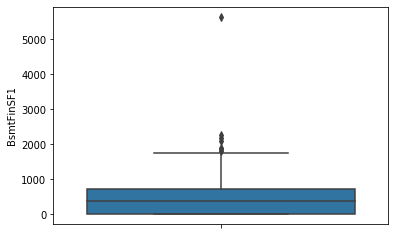

In [51]:
sns.boxplot(data=training, y='BsmtFinSF1')

In [52]:
print(training.BsmtFinType2.value_counts())
training.BsmtFinType2.fillna('NA', inplace=True)
print(training.BsmtFinType2.value_counts())

training.BsmtFinType2 = fin_type_enc.fit_transform(training[['BsmtFinType2']])
training.BsmtFinType2.value_counts()

Unf    1256
Rec      54
LwQ      46
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64
Unf    1256
Rec      54
LwQ      46
NA       38
BLQ      33
ALQ      19
GLQ      14
Name: BsmtFinType2, dtype: int64


1.0    1256
3.0      54
2.0      46
0.0      38
4.0      33
5.0      19
6.0      14
Name: BsmtFinType2, dtype: int64

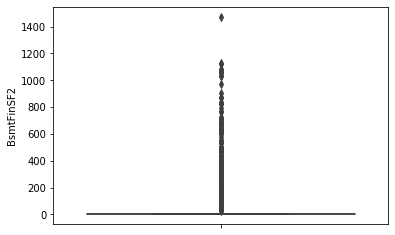

In [53]:
sns.boxplot(y = training.BsmtFinSF2)

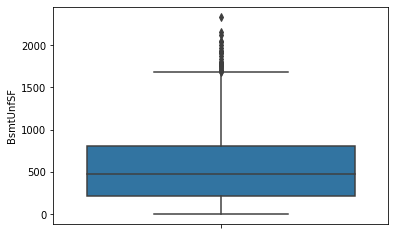

In [54]:
sns.boxplot(y=training.BsmtUnfSF)

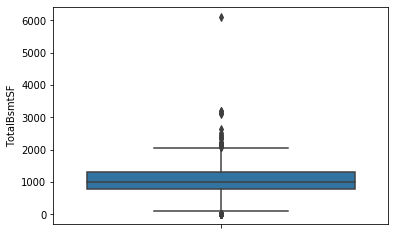

In [55]:
sns.boxplot(y=training.TotalBsmtSF)

In [56]:
training.Heating.value_counts()
gas = ['GasA', 'GasW']

training['Gas'] = training.Heating.apply(lambda x: 1 if x in gas else 0)
training.Gas.value_counts()

1    1446
0      14
Name: Gas, dtype: int64

In [57]:
training.HeatingQC.value_counts()
training.HeatingQC = ex_po_ord.fit_transform(training[['HeatingQC']])
training.HeatingQC.value_counts()

5.0    741
3.0    428
4.0    241
2.0     49
1.0      1
Name: HeatingQC, dtype: int64

In [58]:
training.CentralAir.value_counts()
training.CentralAir = training.CentralAir.apply(lambda x: 1 if x =='Y' else 0)
training.CentralAir.value_counts()

1    1365
0      95
Name: CentralAir, dtype: int64

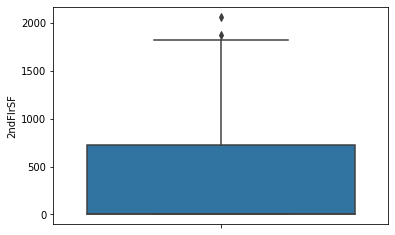

In [59]:
sns.boxplot(y=training['2ndFlrSF'])

In [60]:
print(training.Electrical.value_counts())
print(training.Electrical.isnull().sum().sum())
training.Electrical.fillna('SBrkr', inplace=True)

elec_others = ['FuseF', 'FuseP', 'Mix']
training.Electrical = training.Electrical.apply(lambda x: 'Other' if x in elec_others else x)
training.Electrical.value_counts()


SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64
1


SBrkr    1335
FuseA      94
Other      31
Name: Electrical, dtype: int64

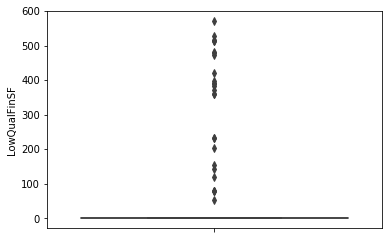

In [61]:
sns.boxplot(y=training.LowQualFinSF)

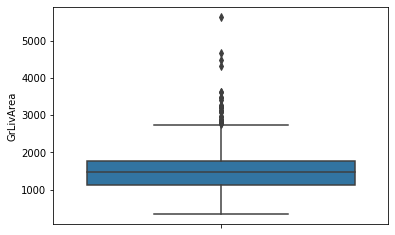

In [62]:
sns.boxplot(y=training.GrLivArea)

In [63]:
training.BsmtFullBath.value_counts()

0    856
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

In [64]:
training.BsmtHalfBath.value_counts()

0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64

In [65]:
training.FullBath.value_counts()

2    768
1    650
3     33
0      9
Name: FullBath, dtype: int64

In [66]:
training.HalfBath.value_counts()

0    913
1    535
2     12
Name: HalfBath, dtype: int64

In [67]:
training.BedroomAbvGr.value_counts()

3    804
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

In [68]:
training.KitchenAbvGr.value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [69]:
print(training.KitchenQual.value_counts())
training.KitchenQual = ex_po_ord.fit_transform(training[['KitchenQual']])
training.KitchenQual.value_counts()

TA    735
Gd    586
Ex    100
Fa     39
Name: KitchenQual, dtype: int64


3.0    735
4.0    586
5.0    100
2.0     39
Name: KitchenQual, dtype: int64

In [70]:
#       Typ	Typical Functionality
#       Min1	Minor Deductions 1
#       Min2	Minor Deductions 2
#       Mod	Moderate Deductions
#       Maj1	Major Deductions 1
#       Maj2	Major Deductions 2
#       Sev	Severely Damaged
#       Sal	Salvage only
print(training.Functional.value_counts())
func = ['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ']
func_ord = OrdinalEncoder(categories=[func])

training.Functional = func_ord.fit_transform(training[['Functional']])
training.Functional.value_counts()


Typ     1360
Min2      34
Min1      31
Mod       15
Maj1      14
Maj2       5
Sev        1
Name: Functional, dtype: int64


7.0    1360
5.0      34
6.0      31
4.0      15
3.0      14
2.0       5
1.0       1
Name: Functional, dtype: int64

In [71]:
training.Fireplaces.value_counts()

0    690
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

In [72]:
print(training.FireplaceQu.value_counts())
training.FireplaceQu.fillna('NA', inplace=True)
print(training.FireplaceQu.value_counts())

training.FireplaceQu = ex_po_ord.fit_transform(training[['FireplaceQu']])
training.FireplaceQu.value_counts()

Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64
NA    690
Gd    380
TA    313
Fa     33
Ex     24
Po     20
Name: FireplaceQu, dtype: int64


0.0    690
4.0    380
3.0    313
2.0     33
5.0     24
1.0     20
Name: FireplaceQu, dtype: int64

In [73]:
training.GarageType.value_counts()
training.GarageType.fillna('None', inplace=True)
training.GarageType.value_counts()
garage_others = ['Basement', 'CarPort', '2Types', 'Basment']

training.GarageType = training.GarageType.apply(lambda x: 'Other' if x in garage_others else x)
training.GarageType.value_counts()

Attchd     870
Detchd     387
BuiltIn     88
None        81
Other       34
Name: GarageType, dtype: int64

In [74]:
training.GarageFinish.value_counts()
training.GarageFinish.fillna('None', inplace=True)
training.GarageFinish.value_counts()

Unf     605
RFn     422
Fin     352
None     81
Name: GarageFinish, dtype: int64

In [75]:
training.GarageCars.value_counts()

2    824
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

In [76]:
training.GarageQual.value_counts()
training.GarageQual.fillna('NA', inplace=True)
training.GarageQual = ex_po_ord.fit_transform(training[['GarageQual']])
training.GarageQual.value_counts()

3.0    1311
0.0      81
2.0      48
4.0      14
1.0       3
5.0       3
Name: GarageQual, dtype: int64

In [77]:
training.GarageCond.value_counts()
training.GarageCond.fillna('NA', inplace=True)
training.GarageCond = ex_po_ord.fit_transform(training[['GarageCond']])
training.GarageCond.value_counts()

3.0    1326
0.0      81
2.0      35
4.0       9
1.0       7
5.0       2
Name: GarageCond, dtype: int64

In [78]:
training.PavedDrive.value_counts()
pave = ['N', 'P', 'Y']
pave_ord = OrdinalEncoder(categories=[pave])

training.PavedDrive = pave_ord.fit_transform(training[['PavedDrive']])
training.PavedDrive.value_counts()

2.0    1340
0.0      90
1.0      30
Name: PavedDrive, dtype: int64

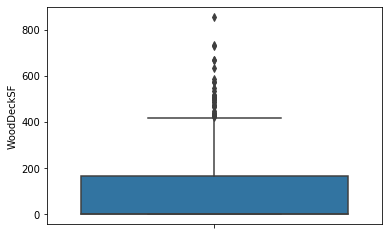

In [79]:
sns.boxplot(y=training.WoodDeckSF)

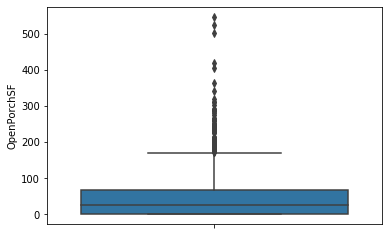

In [80]:
sns.boxplot(y=training.OpenPorchSF)

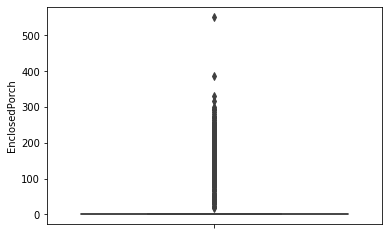

In [81]:
sns.boxplot(y=training.EnclosedPorch)

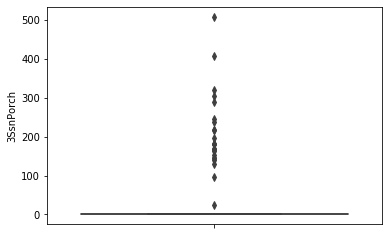

In [82]:
sns.boxplot(y=training['3SsnPorch'])

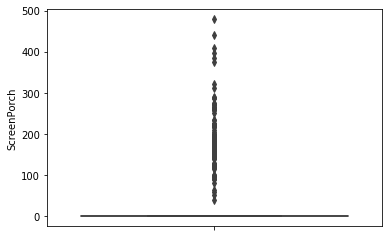

In [83]:
sns.boxplot(y=training.ScreenPorch)

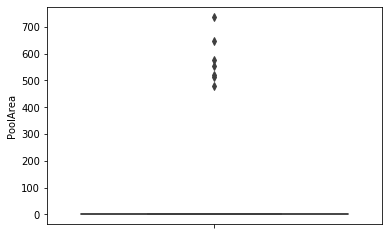

In [84]:
sns.boxplot(y=training.PoolArea)

In [85]:
training.PoolQC.value_counts()
training.PoolQC.fillna('NA', inplace=True)
training.PoolQC = ex_po_ord.fit_transform(training[['PoolQC']])
training.PoolQC.value_counts()

0.0    1453
4.0       3
2.0       2
5.0       2
Name: PoolQC, dtype: int64

In [86]:
#       GdPrv	Good Privacy
#       MnPrv	Minimum Privacy
#       GdWo	Good Wood
#       MnWw	Minimum Wood/Wire
#       NA	No Fence
training.Fence.value_counts()
fence = ['NA', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv']
fence_ord = OrdinalEncoder(categories=[fence])

training.Fence.fillna('NA', inplace=True)
training.Fence = fence_ord.fit_transform(training[['Fence']])
training.Fence.value_counts()


0.0    1179
3.0     157
4.0      59
2.0      54
1.0      11
Name: Fence, dtype: int64

In [87]:
training.MiscFeature.value_counts()
training.MiscFeature.fillna("NA", inplace=True)
training.MiscFeature = training.MiscFeature.apply(lambda x: 0 if x == 'NA' else 1)
training.MiscFeature.value_counts()

0    1406
1      54
Name: MiscFeature, dtype: int64

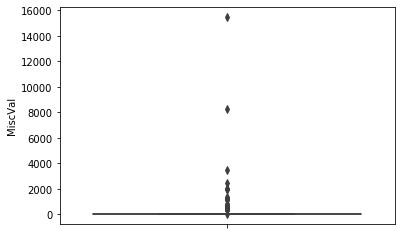

In [88]:
sns.boxplot(y=training.MiscVal)

In [89]:
training.MoSold.value_counts()


6     253
7     234
5     204
4     141
8     122
3     106
10     89
11     79
9      63
12     59
1      58
2      52
Name: MoSold, dtype: int64

In [90]:
training.YrSold.value_counts()
training['SaleAge'] = training.YrSold.apply(lambda x: year - x)
training.SaleAge.value_counts()

12    338
14    329
15    314
13    304
11    175
Name: SaleAge, dtype: int64

In [91]:
training.SaleType.value_counts()
sale_common = ['WD', 'New', 'COD']
training.SaleType = training.SaleType.apply(lambda x: x if x in sale_common else 'Other')
training.SaleType.value_counts()

WD       1267
New       122
COD        43
Other      28
Name: SaleType, dtype: int64

In [92]:
training.SaleCondition.value_counts()
cond_others = ['Family', 'Alloca', 'AdjLand']
training.SaleCondition = training.SaleCondition.apply(lambda x: 'Other' if x in cond_others else x)
training.SaleCondition.value_counts()

Normal     1198
Partial     125
Abnorml     101
Other        36
Name: SaleCondition, dtype: int64

# Train Test Split

Before I did the test train split, I applied the transformations to the DF that included all the data. I also ended up adding some to the null value section that occured in the test data and not the train data.

Due to the large amount of 0s in the data, I did not end up normalizing it. Instead, I used models that would deal with it better.

In [93]:
# Filling null values
all_data.MasVnrType.fillna('None', inplace=True)
all_data.MasVnrArea.fillna(0, inplace=True)
all_data.BsmtCond.fillna('NA', inplace=True)
all_data.BsmtQual.fillna('NA', inplace=True)
all_data.BsmtExposure.fillna('NA', inplace=True)
all_data.BsmtFinType1.fillna('NA', inplace=True)
all_data.BsmtFinSF1.fillna(0, inplace=True)
all_data.BsmtFinType2.fillna('NA', inplace=True)
all_data.BsmtFinSF2.fillna(0, inplace=True)
all_data.BsmtUnfSF.fillna(0, inplace=True)
all_data.TotalBsmtSF.fillna(0, inplace=True)
all_data.BsmtFullBath.fillna(0, inplace=True)
all_data.BsmtHalfBath.fillna(0, inplace=True)
all_data.Electrical.fillna('SBrkr', inplace=True)
all_data.GarageType.fillna('None', inplace=True)
all_data.GarageFinish.fillna('None', inplace=True)
all_data.GarageQual.fillna('NA', inplace=True)
all_data.GarageCond.fillna('NA', inplace=True)
all_data.GarageCars.fillna(0, inplace=True)
all_data.PoolQC.fillna('NA', inplace=True)
all_data.Fence.fillna('NA', inplace=True)
all_data.MiscFeature.fillna("NA", inplace=True)
all_data.KitchenQual.fillna('TA', inplace=True)
all_data.Functional.fillna('Typ', inplace=True)
all_data.FireplaceQu.fillna('NA', inplace=True)
all_data.LotFrontage.fillna(training.LotFrontage.median(), inplace=True)
all_data.Exterior1st.fillna('Other', inplace=True)
all_data.Exterior2nd.fillna('Other', inplace=True)


# Transforming columns
all_data.MSSubClass = all_data.MSSubClass.apply(lambda x: str('other') if x in mssub_others else str(x))
all_data.MSZoning = all_data.MSZoning.apply(lambda x: str('Other') if x in mszoning_others else str(x))
all_data.LotShape = all_data.LotShape.apply(lambda x: 'Other' if x in lotshape_others else x)
all_data.Alley = all_data.Alley.apply(lambda x: 1 if type(x) == str else 0)
all_data.LotConfig = all_data.LotConfig.apply(lambda x: 'Other' if x == 'FR2' or x == 'FR3' else x)
all_data.Condition1 = all_data.Condition1.apply(lambda x: 'Pos' if x in pos_condition else x)
all_data.Condition1 = all_data.Condition1.apply(lambda x: 'RR' if x in rr_condition else x)
all_data.Condition2 = all_data.Condition2.apply(lambda x: 'Pos' if x in pos_condition else x)
all_data.Condition2 = all_data.Condition2.apply(lambda x: 'RR' if x in rr_condition else x)
all_data.Exterior1st = all_data.Exterior1st.apply(lambda x: 'Other' if x in ext1_others else x)
all_data.Exterior2nd = all_data.Exterior2nd.apply(lambda x: 'Other' if x in ext2_others else x)
all_data.Foundation = all_data.Foundation.apply(lambda x: 'Other' if x in found_others else x)
all_data.CentralAir = all_data.CentralAir.apply(lambda x: 1 if x =='Y' else 0)
all_data.Electrical = all_data.Electrical.apply(lambda x: 'Other' if x in elec_others else x)
all_data.GarageType = all_data.GarageType.apply(lambda x: 'Other' if x in garage_others else x)
all_data.MiscFeature = all_data.MiscFeature.apply(lambda x: 0 if x == 'NA' else 1)
all_data.SaleType = all_data.SaleType.apply(lambda x: x if x in sale_common else 'Other')
all_data.SaleType = all_data.SaleType.apply(lambda x: x if x in sale_common else 'Other')


# Changing columns to Ordinal
all_data.ExterQual = ex_po_ord.fit_transform(all_data[['ExterQual']])
all_data.ExterCond = ex_po_ord.fit_transform(all_data[['ExterCond']])
all_data.BsmtQual = ex_po_ord.fit_transform(all_data[['BsmtQual']])
all_data.BsmtCond = ex_po_ord.fit_transform(all_data[['BsmtCond']])
all_data.BsmtExposure = bs_ex_ord.fit_transform(all_data[['BsmtExposure']])
all_data.BsmtFinType1 = fin_type_enc.fit_transform(all_data[['BsmtFinType1']])
all_data.BsmtFinType2 = fin_type_enc.fit_transform(all_data[['BsmtFinType2']])
all_data.HeatingQC = ex_po_ord.fit_transform(all_data[['HeatingQC']])
all_data.KitchenQual = ex_po_ord.fit_transform(all_data[['KitchenQual']])
all_data.Functional = func_ord.fit_transform(all_data[['Functional']])
all_data.FireplaceQu = ex_po_ord.fit_transform(all_data[['FireplaceQu']])
all_data.GarageQual = ex_po_ord.fit_transform(all_data[['GarageQual']])
all_data.GarageCond = ex_po_ord.fit_transform(all_data[['GarageCond']])
all_data.PoolQC = ex_po_ord.fit_transform(all_data[['PoolQC']])
all_data.Fence = fence_ord.fit_transform(all_data[['Fence']])


# Adding new columns with more descriptive names
all_data['Street_Pave'] = all_data.Street.apply(lambda x: 1 if x == 'Pave' else 0)
all_data['LandContour_Flat'] = all_data.LandContour.apply(lambda x: 1 if x == 'Lvl' else 0)
all_data['LandSlope_Gentle'] = all_data.LandSlope.apply(lambda x: 1 if x == 'Gtl' else 0)
all_data['Year_Old'] = all_data.YearBuilt.apply(lambda x: year - x)
all_data['Year_Old'] = all_data.YearBuilt.apply(lambda x: year - x)
all_data['Gable_Roof'] = all_data.RoofStyle.apply(lambda x: 1 if x == 'Gable' else 0)
all_data['Comp_Roof'] = all_data.RoofMatl.apply(lambda x: 1 if x == 'CompShg' else 0)
all_data['Gas'] = all_data.Heating.apply(lambda x: 1 if x in gas else 0)
all_data['SaleAge'] = all_data.YrSold.apply(lambda x: year - x)

# Dropping columns that were replaced above
all_data.drop(['MiscFeature', 'Fence', 'PoolQC', 'Alley', 'YrSold', 'Heating', 'RoofMatl', 'RoofStyle', 'YearRemodAdd', 'YearBuilt', 'LandSlope', 
               'LandContour', 'Street', 'Utilities'], axis=1, inplace=True)

# Dropping highly correlated columns
all_data.drop(columns=corr_array, inplace=True)

# One hot encoding
all_dummies = pd.get_dummies(all_data)
X_train = all_dummies[all_dummies.train_test == 1].drop(['train_test', 'SalePrice'], axis =1)
X_test = all_dummies[all_dummies.train_test == 0].drop(['train_test', 'SalePrice'], axis =1)

y_train = all_data[all_data.train_test == 1].SalePrice



# Modeling

In [94]:
xgb = XGBRegressor(random_state=0)
cv = cross_val_score(xgb, X_train, y_train, cv=5)
cv.mean()

0.8548830131108669

In [95]:
rf = RandomForestRegressor(random_state=0)
cv = cross_val_score(rf, X_train, y_train, cv=5)
cv.mean()

0.8570898417698507

# Model Tuning

In [96]:
from sklearn.model_selection import GridSearchCV


params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}
xgbr = XGBRegressor(seed = 20)
clf = GridSearchCV(estimator=xgbr, 
                    param_grid=params,
                    scoring='neg_mean_squared_error', 
                    verbose=1)
clf.fit(X_train, y_train)
print("Best parameters:", clf.best_params_)


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  5.0min finished


Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 1000}


In [97]:
xgb_final = XGBRegressor(colsample_bytree = 0.3, learning_rate = 0.05, max_depth = 3, n_estimators = 1000)
cv = cross_val_score(xgb_final, X_train, y_train, cv=5)
cv.mean()

0.894733825658044

# Results


In [99]:
xgb_final.fit(X_train, y_train)

pred = xgb_final.predict(X_test)

output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': pred})
output.to_csv('submission_v2.csv', index=False)